In [1]:
# Parameters (overridden during execution)
EPOCHS = 25
RUN_ID = 1
OUT_DIR = "/kaggle/working/outputs"

In [2]:
!pip install torchinfo
!pip install --quiet torchview graphviz

In [3]:
import os
import math
import time
import random
import multiprocessing
from datetime import timedelta
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG, display

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from timm.models.vision_transformer import VisionTransformer, PatchEmbed
from torchinfo import summary
from torchview import draw_graph

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import random_split
from collections import Counter

In [6]:
!unzip -q "/content/archive (10).zip" -d /content/lung_cancer

In [7]:
import os
from pathlib import Path
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [8]:
BASE_ROOT  = Path("/content/lung_cancer/Data")
TRAIN_ROOT = BASE_ROOT / "train"
VAL_ROOT   = BASE_ROOT / "valid"
TEST_ROOT  = BASE_ROOT / "test"

assert TRAIN_ROOT.exists(), "Train folder not found"
assert VAL_ROOT.exists(),   "Valid folder not found"
assert TEST_ROOT.exists(),  "Test folder not found"


In [9]:
from torch.utils.data import Dataset, DataLoader

# -------------------------
# PyTorch Dataset
# -------------------------
class LungDataset(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.class_names = sorted([
            d for d in os.listdir(root)
            if (root / d).is_dir()
        ])
        self.class_to_idx = {c: i for i, c in enumerate(self.class_names)}
        self.transform = transform

        for cls in self.class_names:
            cls_dir = root / cls
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append(
                        (cls_dir / img_name, self.class_to_idx[cls])
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img, label


In [10]:
IMG_SIZE   = 224     # MUST match model input
BATCH_SIZE = 6

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # shape only
    transforms.ToTensor(),                    # required by PyTorch
])


In [11]:
train_ds = LungDataset(TRAIN_ROOT, transform)
val_ds   = LungDataset(VAL_ROOT,   transform)
test_ds  = LungDataset(TEST_ROOT,  transform)


In [12]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

print("Detected classes:")
for i, name in enumerate(CLASS_NAMES):
    print(f"{i}: {name}")

print(f"\nNumber of classes: {NUM_CLASSES}")


Detected classes:
0: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
1: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
2: normal
3: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa

Number of classes: 4


In [23]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True   # 🔥 ADD THIS
)


val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [24]:
def show_random_images_per_class(
    dataset,
    class_names,
    n_per_class=5,
    seed=42
):
    random.seed(seed)
    torch.manual_seed(seed)

    # Extract labels
    labels = np.array([label for _, label in dataset])
    num_classes = len(class_names)

    fig, axes = plt.subplots(
        num_classes,
        n_per_class,
        figsize=(3 * n_per_class, 3 * num_classes),
        squeeze=False
    )

    for cls_idx in range(num_classes):
        cls_indices = np.where(labels == cls_idx)[0]
        selected = np.random.choice(
            cls_indices,
            size=min(n_per_class, len(cls_indices)),
            replace=False
        )

        for col, idx in enumerate(selected):
            img, _ = dataset[idx]
            img = img.permute(1, 2, 0).numpy()

            ax = axes[cls_idx, col]
            ax.imshow(img)
            ax.axis("off")

            if col == 0:
                ax.set_ylabel(
                    class_names[cls_idx],
                    fontsize=12,
                    rotation=90,
                    labelpad=10
                )

    plt.tight_layout()
    plt.show()


In [25]:
class TwoMaxMinusMinPool2d(nn.Module):
    """
    Pooling layer that computes:
        output = (2 * max_pool) - min_pool

    Uses only optimized max-pooling kernels.
    Computational cost ~ 2× max pooling.
    Output shape matches standard pooling.
    """

    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()

        # Match PyTorch pooling semantics
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, x):
        # Fast max pooling (optimized C++/CUDA)
        max_pool = F.max_pool2d(
            x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        # Fast min pooling via negation trick
        min_pool = -F.max_pool2d(
            -x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        # Final contrast-enhanced response
        return (2.0 * max_pool) - min_pool

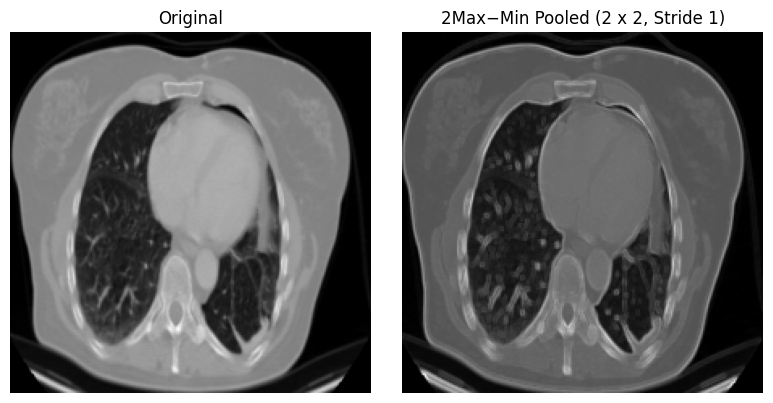

In [26]:
KERNEL_SIZE = 2
STRIDE = 1

# Get one batch
images, labels = next(iter(train_loader))

# Take first image only
img = images[0:1]  # shape: (1, C, H, W)

pool = TwoMaxMinusMinPool2d(kernel_size=KERNEL_SIZE, stride=STRIDE)
pool.eval()

with torch.no_grad():
    pooled = pool(img)

# Convert to numpy for display
img_np = img[0].cpu().numpy()
pooled_np = pooled[0].cpu().numpy()

# Pick one channel to visualize
ch = 0

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(img_np[ch], cmap="gray")
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(pooled_np[ch], cmap="gray")
axs[1].set_title(F"2Max−Min Pooled ({KERNEL_SIZE} x {KERNEL_SIZE}, Stride {STRIDE})")
axs[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from timm.models.vision_transformer import VisionTransformer


class CNN_ViT_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        pretrained_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        num_blocks1 = len(pretrained_model.features)

        # Freeze first half
        for param in pretrained_model.features[:num_blocks1 // 2].parameters():
            param.requires_grad = False

        # Split MobileNetV2
        self.mobilenet_feature_blocks_1 = nn.Sequential(
            *pretrained_model.features[:num_blocks1 - 3]
        )
        self.mobilenet_block_2nd_last = pretrained_model.features[num_blocks1 - 3]
        self.mobilenet_block_mid = pretrained_model.features[num_blocks1 - 2]
        self.mobilenet_block_last = pretrained_model.features[num_blocks1 - 1]

        # Channel sizes
        ch_2nd_last = self.mobilenet_block_2nd_last.out_channels   # 160
        ch_mid = self.mobilenet_block_mid.out_channels             # 320
        ch_last = self.mobilenet_block_last.out_channels           # 1280
        ch_concat = ch_last + ch_2nd_last                          # 1440

        self.cnn_to_vit_adapter = nn.Sequential(
            nn.Conv2d(ch_mid, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(14, 14), mode="bilinear", align_corners=False),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False),

            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Upsample(size=(56, 56), mode="bilinear", align_corners=False),
        )

        self.vit_encoder1 = VisionTransformer(
            img_size=56,
            patch_size=8,
            in_chans=16,
            num_classes=0,
            embed_dim=48,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder1.head = nn.Identity()

        # Enable overlapping patches
        old_proj = self.vit_encoder1.patch_embed.proj
        self.vit_encoder1.patch_embed.proj = nn.Conv2d(
            old_proj.in_channels,
            old_proj.out_channels,
            kernel_size=8,
            stride=4,
            bias=old_proj.bias is not None,
        )

        # Update patch count
        img_h, img_w = self.vit_encoder1.patch_embed.img_size
        dummy = torch.zeros(1, old_proj.in_channels, img_h, img_w)

        with torch.no_grad():
            _, _, h, w = self.vit_encoder1.patch_embed.proj(dummy).shape

        num_patches = h * w
        self.vit_encoder1.patch_embed.num_patches = num_patches
        self.vit_encoder1.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, self.vit_encoder1.embed_dim)
        )
        nn.init.trunc_normal_(self.vit_encoder1.pos_embed, std=0.02)

        self.twomax_minus_min_pool = TwoMaxMinusMinPool2d(
            kernel_size=2,
            stride=1
        )

        self.post_pool_gelu = nn.GELU()

        self.vit_encoder2 = VisionTransformer(
            img_size=28,
            patch_size=7,
            in_chans=32,
            num_classes=0,
            embed_dim=48,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder2.head = nn.Identity()

        self.cnn_parallel_head = nn.Sequential(
            nn.Conv2d(ch_concat, 128, kernel_size=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
        )

        self.fusion_dim = 48 + 48 + 128
        self.efm_bn = nn.BatchNorm1d(self.fusion_dim)

        # Final classifier
        self.classifier_head = nn.Linear(self.fusion_dim, num_classes)

    def forward(self, x):

        # ----- MobileNet feature extraction -----
        features_1 = self.mobilenet_feature_blocks_1(x)
        features_2nd_last = self.mobilenet_block_2nd_last(features_1)
        features_mid = self.mobilenet_block_mid(features_2nd_last)
        features_last = self.mobilenet_block_last(features_mid)

        concatenated_cnn_features = torch.cat(
            [features_last, features_2nd_last], dim=1
        )

        # ----- CNN → ViT adapter -----
        x = features_mid
        intermediate = None

        for i, layer in enumerate(self.cnn_to_vit_adapter):
            x = layer(x)

            if i == len(self.cnn_to_vit_adapter) - 5:
                intermediate = x

        vit_input1 = x
        vit_input2 = intermediate

        # ----- ViT 1 -----
        vit_features1 = self.vit_encoder1(vit_input1)

        # ----- Pool + ViT 2 -----
        vit_input2 = self.twomax_minus_min_pool(vit_input2)
        vit_input2 = self.post_pool_gelu(vit_input2)

        vit_input2 = F.interpolate(
            vit_input2,
            size=(28, 28),
            mode="bilinear",
            align_corners=False
        )

        vit_features2 = self.vit_encoder2(vit_input2)

        cnn_features = self.cnn_parallel_head(concatenated_cnn_features)

        combined = torch.cat(
            [vit_features1, vit_features2, cnn_features],
            dim=1
        )

        combined = self.efm_bn(combined)

        # Final classification
        return self.classifier_head(combined)


In [28]:
model = CNN_ViT_Model(num_classes=NUM_CLASSES)
model.to(device)
summary(model, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
CNN_ViT_Model                                      [1, 3, 224, 224]          [1, 4]                    --                        Partial
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 160, 7, 7]            --                        Partial
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual: 2-2                      

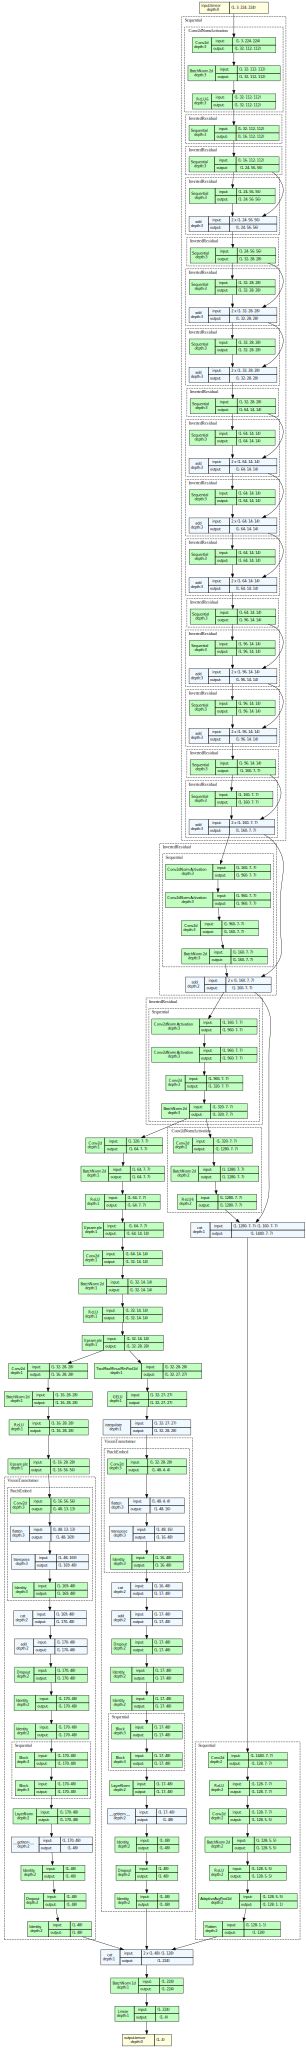

In [29]:
model.to(device)

# Dummy input (can adjust shape based on your model's expected input)
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Generate the graph — expand_nested=True if model has nested submodules
model_graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    graph_name="CNN_ViT_Model",
    save_graph=False  # We don't want to save, only display inline
)

# Render to SVG and display inline in the notebook
svg_output = model_graph.visual_graph.pipe(format='svg')
display(SVG(svg_output))

In [30]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0.0

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()

        # Skip AUC if only one class is present
        if np.unique(class_y_true).size < 2:
            continue
        try:
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        except ValueError:
            continue

    auc_avg = np.mean(auc_scores) if auc_scores else 0.0

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [31]:
# Hyperparameters
num_epochs       = EPOCHS
initial_lr       = 2e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [32]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric: [] for metric in metric_names}
val_metrics_history = {metric: [] for metric in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training loop
    model.train()
    total_train_loss = 0.0
    all_train_predictions = []
    all_train_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        all_train_predictions.extend(outputs.detach().cpu().numpy())
        all_train_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    average_train_loss = total_train_loss / len(train_loader)
    all_train_predictions = np.array(all_train_predictions)
    all_train_targets = np.array(all_train_targets)

    train_metrics = custom_metrics(torch.tensor(all_train_predictions), torch.tensor(all_train_targets), average_train_loss)
    training_metrics_line = "Train Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(training_metrics_line)

    for metric in metric_names:
        train_metrics_history[metric].append(train_metrics[metric])

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    all_val_predictions = []
    all_val_targets = []
    start_val_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            all_val_predictions.extend(outputs.detach().cpu().numpy())
            all_val_targets.extend(targets.detach().cpu().numpy())

    end_val_time = time.time()
    epoch_validation_time = end_val_time - start_val_time
    total_validation_time += epoch_validation_time

    average_val_loss = total_val_loss / len(val_loader)
    all_val_predictions = np.array(all_val_predictions)
    all_val_targets = np.array(all_val_targets)

    val_metrics = custom_metrics(torch.tensor(all_val_predictions), torch.tensor(all_val_targets), average_val_loss)
    validation_metrics_line = "Val Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(validation_metrics_line)

    for metric in metric_names:
        val_metrics_history[metric].append(val_metrics[metric])

    # Update LR via scheduler rather than manual mutliplication
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.4f} — LR: {current_lr:.6f}")

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / (epoch + 1)
avg_validation_time_per_epoch = total_validation_time / (epoch + 1)
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Epoch [1/25]: 100%|██████████| 102/102 [00:06<00:00, 16.17it/s]


Train Metrics - loss: 0.8984, accuracy: 0.6078, precision: 0.5968, recall: 0.6078, f1_score: 0.5983, specificity: 0.4923, sensitivity: 0.8321, mcc: 0.4754, auc: 0.8325


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.47it/s]


Val Metrics - loss: 0.7176, accuracy: 0.6944, precision: 0.7309, recall: 0.6944, f1_score: 0.6862, specificity: 0.3913, sensitivity: 0.9388, mcc: 0.6092, auc: 0.9146
Epoch 0/25 — Loss: 0.5557 — LR: 0.000200


Training Epoch [2/25]: 100%|██████████| 102/102 [00:04<00:00, 20.70it/s]


Train Metrics - loss: 0.4039, accuracy: 0.8627, precision: 0.8617, recall: 0.8627, f1_score: 0.8615, specificity: 0.8351, sensitivity: 0.9234, mcc: 0.8154, auc: 0.9586


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.08it/s]


Val Metrics - loss: 0.4909, accuracy: 0.8194, precision: 0.8734, recall: 0.8194, f1_score: 0.8224, specificity: 0.6087, sensitivity: 1.0000, mcc: 0.7754, auc: 0.9518
Epoch 1/25 — Loss: 0.4010 — LR: 0.000200


Training Epoch [3/25]: 100%|██████████| 102/102 [00:05<00:00, 17.63it/s]


Train Metrics - loss: 0.2181, accuracy: 0.9265, precision: 0.9267, recall: 0.9265, f1_score: 0.9265, specificity: 0.9077, sensitivity: 0.9712, mcc: 0.9010, auc: 0.9844


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 15.60it/s]


Val Metrics - loss: 0.4492, accuracy: 0.8472, precision: 0.8692, recall: 0.8472, f1_score: 0.8523, specificity: 0.8696, sensitivity: 0.9388, mcc: 0.7974, auc: 0.9552
Epoch 2/25 — Loss: 0.8368 — LR: 0.000200


Training Epoch [4/25]: 100%|██████████| 102/102 [00:05<00:00, 19.88it/s]


Train Metrics - loss: 0.2230, accuracy: 0.9265, precision: 0.9268, recall: 0.9265, f1_score: 0.9263, specificity: 0.9231, sensitivity: 0.9592, mcc: 0.9010, auc: 0.9841


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.07it/s]


Val Metrics - loss: 0.3832, accuracy: 0.8611, precision: 0.8854, recall: 0.8611, f1_score: 0.8659, specificity: 0.8261, sensitivity: 0.9796, mcc: 0.8181, auc: 0.9647
Epoch 3/25 — Loss: 0.7048 — LR: 0.000200


Training Epoch [5/25]: 100%|██████████| 102/102 [00:05<00:00, 18.51it/s]


Train Metrics - loss: 0.1916, accuracy: 0.9493, precision: 0.9496, recall: 0.9493, f1_score: 0.9492, specificity: 0.9077, sensitivity: 0.9784, mcc: 0.9320, auc: 0.9867


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 14.16it/s]


Val Metrics - loss: 0.4117, accuracy: 0.8472, precision: 0.8751, recall: 0.8472, f1_score: 0.8497, specificity: 0.9565, sensitivity: 0.8980, mcc: 0.7992, auc: 0.9686
Epoch 4/25 — Loss: 0.3571 — LR: 0.000200


Training Epoch [6/25]: 100%|██████████| 102/102 [00:05<00:00, 20.04it/s]


Train Metrics - loss: 0.1580, accuracy: 0.9493, precision: 0.9494, recall: 0.9493, f1_score: 0.9493, specificity: 0.9227, sensitivity: 0.9737, mcc: 0.9318, auc: 0.9907


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.54it/s]


Val Metrics - loss: 0.3191, accuracy: 0.8750, precision: 0.8959, recall: 0.8750, f1_score: 0.8786, specificity: 0.9565, sensitivity: 0.9388, mcc: 0.8349, auc: 0.9721
Epoch 5/25 — Loss: 0.3042 — LR: 0.000200


Training Epoch [7/25]: 100%|██████████| 102/102 [00:05<00:00, 20.01it/s]


Train Metrics - loss: 0.1792, accuracy: 0.9395, precision: 0.9400, recall: 0.9395, f1_score: 0.9397, specificity: 0.9278, sensitivity: 0.9713, mcc: 0.9185, auc: 0.9887


Validating Model: 100%|██████████| 12/12 [00:01<00:00, 11.54it/s]


Val Metrics - loss: 0.4422, accuracy: 0.8611, precision: 0.9059, recall: 0.8611, f1_score: 0.8690, specificity: 0.8261, sensitivity: 0.9796, mcc: 0.8254, auc: 0.9837
Epoch 6/25 — Loss: 0.0257 — LR: 0.000200


Training Epoch [8/25]: 100%|██████████| 102/102 [00:05<00:00, 19.49it/s]


Train Metrics - loss: 0.1976, accuracy: 0.9379, precision: 0.9388, recall: 0.9379, f1_score: 0.9380, specificity: 0.9227, sensitivity: 0.9737, mcc: 0.9166, auc: 0.9865


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 22.06it/s]


Val Metrics - loss: 0.3673, accuracy: 0.8472, precision: 0.8560, recall: 0.8472, f1_score: 0.8468, specificity: 0.7391, sensitivity: 0.9592, mcc: 0.7965, auc: 0.9813
Epoch 7/25 — Loss: 0.4746 — LR: 0.000200


Training Epoch [9/25]: 100%|██████████| 102/102 [00:05<00:00, 20.30it/s]


Train Metrics - loss: 0.1341, accuracy: 0.9657, precision: 0.9657, recall: 0.9657, f1_score: 0.9657, specificity: 0.9692, sensitivity: 0.9832, mcc: 0.9537, auc: 0.9931


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 12.11it/s]


Val Metrics - loss: 0.2363, accuracy: 0.8889, precision: 0.9083, recall: 0.8889, f1_score: 0.8923, specificity: 0.8261, sensitivity: 1.0000, mcc: 0.8554, auc: 0.9885
Epoch 8/25 — Loss: 0.2923 — LR: 0.000200


Training Epoch [10/25]: 100%|██████████| 102/102 [00:05<00:00, 18.15it/s]


Train Metrics - loss: 0.0876, accuracy: 0.9739, precision: 0.9741, recall: 0.9739, f1_score: 0.9739, specificity: 0.9742, sensitivity: 0.9904, mcc: 0.9648, auc: 0.9958


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.40it/s]


Val Metrics - loss: 0.2649, accuracy: 0.8889, precision: 0.9097, recall: 0.8889, f1_score: 0.8926, specificity: 0.9130, sensitivity: 0.9592, mcc: 0.8548, auc: 0.9821
Epoch 9/25 — Loss: 0.4339 — LR: 0.000200


Training Epoch [11/25]: 100%|██████████| 102/102 [00:04<00:00, 20.82it/s]


Train Metrics - loss: 0.0775, accuracy: 0.9771, precision: 0.9771, recall: 0.9771, f1_score: 0.9771, specificity: 0.9744, sensitivity: 0.9880, mcc: 0.9691, auc: 0.9963


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 15.92it/s]


Val Metrics - loss: 0.2778, accuracy: 0.9028, precision: 0.9337, recall: 0.9028, f1_score: 0.9086, specificity: 0.8696, sensitivity: 1.0000, mcc: 0.8772, auc: 0.9902
Epoch 10/25 — Loss: 0.0663 — LR: 0.000194


Training Epoch [12/25]: 100%|██████████| 102/102 [00:05<00:00, 17.48it/s]


Train Metrics - loss: 0.0935, accuracy: 0.9755, precision: 0.9756, recall: 0.9755, f1_score: 0.9754, specificity: 0.9846, sensitivity: 0.9832, mcc: 0.9670, auc: 0.9944


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.72it/s]


Val Metrics - loss: 0.3618, accuracy: 0.8750, precision: 0.9219, recall: 0.8750, f1_score: 0.8836, specificity: 0.8261, sensitivity: 1.0000, mcc: 0.8452, auc: 0.9815
Epoch 11/25 — Loss: 0.0646 — LR: 0.000188


Training Epoch [13/25]: 100%|██████████| 102/102 [00:05<00:00, 20.31it/s]


Train Metrics - loss: 0.1239, accuracy: 0.9657, precision: 0.9659, recall: 0.9657, f1_score: 0.9657, specificity: 0.9538, sensitivity: 0.9784, mcc: 0.9537, auc: 0.9914


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 18.73it/s]


Val Metrics - loss: 0.3333, accuracy: 0.8611, precision: 0.8938, recall: 0.8611, f1_score: 0.8678, specificity: 0.8261, sensitivity: 0.9592, mcc: 0.8208, auc: 0.9868
Epoch 12/25 — Loss: 0.0548 — LR: 0.000183


Training Epoch [14/25]: 100%|██████████| 102/102 [00:06<00:00, 16.67it/s]


Train Metrics - loss: 0.0809, accuracy: 0.9739, precision: 0.9742, recall: 0.9739, f1_score: 0.9739, specificity: 0.9639, sensitivity: 0.9856, mcc: 0.9648, auc: 0.9969


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.78it/s]


Val Metrics - loss: 0.3054, accuracy: 0.8750, precision: 0.8992, recall: 0.8750, f1_score: 0.8802, specificity: 0.8261, sensitivity: 0.9796, mcc: 0.8373, auc: 0.9804
Epoch 13/25 — Loss: 0.0479 — LR: 0.000177


Training Epoch [15/25]: 100%|██████████| 102/102 [00:04<00:00, 20.52it/s]


Train Metrics - loss: 0.0803, accuracy: 0.9837, precision: 0.9838, recall: 0.9837, f1_score: 0.9837, specificity: 0.9845, sensitivity: 0.9880, mcc: 0.9780, auc: 0.9954


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.45it/s]


Val Metrics - loss: 0.3625, accuracy: 0.9028, precision: 0.9260, recall: 0.9028, f1_score: 0.9065, specificity: 0.9130, sensitivity: 0.9796, mcc: 0.8745, auc: 0.9838
Epoch 14/25 — Loss: 0.0162 — LR: 0.000172


Training Epoch [16/25]: 100%|██████████| 102/102 [00:06<00:00, 16.69it/s]


Train Metrics - loss: 0.0485, accuracy: 0.9918, precision: 0.9919, recall: 0.9918, f1_score: 0.9918, specificity: 0.9948, sensitivity: 0.9952, mcc: 0.9890, auc: 0.9983


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 20.80it/s]


Val Metrics - loss: 0.4234, accuracy: 0.8750, precision: 0.9219, recall: 0.8750, f1_score: 0.8836, specificity: 0.8696, sensitivity: 1.0000, mcc: 0.8438, auc: 0.9804
Epoch 15/25 — Loss: 0.0434 — LR: 0.000167


Training Epoch [17/25]: 100%|██████████| 102/102 [00:04<00:00, 20.74it/s]


Train Metrics - loss: 0.0655, accuracy: 0.9788, precision: 0.9790, recall: 0.9788, f1_score: 0.9788, specificity: 0.9795, sensitivity: 0.9808, mcc: 0.9714, auc: 0.9955


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 22.16it/s]


Val Metrics - loss: 0.2768, accuracy: 0.9167, precision: 0.9405, recall: 0.9167, f1_score: 0.9206, specificity: 0.8696, sensitivity: 1.0000, mcc: 0.8944, auc: 0.9912
Epoch 16/25 — Loss: 0.0159 — LR: 0.000162


Training Epoch [18/25]: 100%|██████████| 102/102 [00:06<00:00, 16.83it/s]


Train Metrics - loss: 0.0458, accuracy: 0.9935, precision: 0.9935, recall: 0.9935, f1_score: 0.9935, specificity: 0.9948, sensitivity: 0.9952, mcc: 0.9912, auc: 0.9982


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 20.93it/s]


Val Metrics - loss: 0.2467, accuracy: 0.8889, precision: 0.9099, recall: 0.8889, f1_score: 0.8920, specificity: 0.8696, sensitivity: 0.9796, mcc: 0.8555, auc: 0.9919
Epoch 17/25 — Loss: 0.0280 — LR: 0.000157


Training Epoch [19/25]: 100%|██████████| 102/102 [00:05<00:00, 20.07it/s]


Train Metrics - loss: 0.0303, accuracy: 0.9951, precision: 0.9951, recall: 0.9951, f1_score: 0.9951, specificity: 1.0000, sensitivity: 0.9976, mcc: 0.9934, auc: 0.9993


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 20.28it/s]


Val Metrics - loss: 0.1179, accuracy: 0.9167, precision: 0.9334, recall: 0.9167, f1_score: 0.9193, specificity: 0.9130, sensitivity: 0.9796, mcc: 0.8918, auc: 0.9960
Epoch 18/25 — Loss: 0.0144 — LR: 0.000152


Training Epoch [20/25]: 100%|██████████| 102/102 [00:06<00:00, 16.85it/s]


Train Metrics - loss: 0.0615, accuracy: 0.9820, precision: 0.9820, recall: 0.9820, f1_score: 0.9820, specificity: 0.9846, sensitivity: 0.9904, mcc: 0.9758, auc: 0.9973


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 22.14it/s]


Val Metrics - loss: 0.6472, accuracy: 0.8472, precision: 0.8999, recall: 0.8472, f1_score: 0.8563, specificity: 0.7826, sensitivity: 0.9796, mcc: 0.8091, auc: 0.9778
Epoch 19/25 — Loss: 0.0115 — LR: 0.000147


Training Epoch [21/25]: 100%|██████████| 102/102 [00:05<00:00, 20.29it/s]


Train Metrics - loss: 0.0472, accuracy: 0.9869, precision: 0.9870, recall: 0.9869, f1_score: 0.9869, specificity: 0.9897, sensitivity: 0.9928, mcc: 0.9824, auc: 0.9980


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.62it/s]


Val Metrics - loss: 0.3248, accuracy: 0.8889, precision: 0.9275, recall: 0.8889, f1_score: 0.8959, specificity: 0.8696, sensitivity: 1.0000, mcc: 0.8610, auc: 0.9887
Epoch 20/25 — Loss: 0.0229 — LR: 0.000143


Training Epoch [22/25]: 100%|██████████| 102/102 [00:06<00:00, 16.90it/s]


Train Metrics - loss: 0.0504, accuracy: 0.9804, precision: 0.9807, recall: 0.9804, f1_score: 0.9804, specificity: 0.9846, sensitivity: 0.9928, mcc: 0.9736, auc: 0.9977


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.74it/s]


Val Metrics - loss: 0.3464, accuracy: 0.9028, precision: 0.9337, recall: 0.9028, f1_score: 0.9081, specificity: 0.9130, sensitivity: 1.0000, mcc: 0.8773, auc: 0.9836
Epoch 21/25 — Loss: 0.1126 — LR: 0.000139


Training Epoch [23/25]: 100%|██████████| 102/102 [00:04<00:00, 21.06it/s]


Train Metrics - loss: 0.0790, accuracy: 0.9771, precision: 0.9772, recall: 0.9771, f1_score: 0.9771, specificity: 0.9795, sensitivity: 0.9856, mcc: 0.9692, auc: 0.9947


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.41it/s]


Val Metrics - loss: 0.5054, accuracy: 0.8750, precision: 0.9089, recall: 0.8750, f1_score: 0.8828, specificity: 0.8696, sensitivity: 1.0000, mcc: 0.8390, auc: 0.9741
Epoch 22/25 — Loss: 0.1834 — LR: 0.000135


Training Epoch [24/25]: 100%|██████████| 102/102 [00:06<00:00, 17.00it/s]


Train Metrics - loss: 0.0441, accuracy: 0.9902, precision: 0.9902, recall: 0.9902, f1_score: 0.9902, specificity: 0.9948, sensitivity: 0.9976, mcc: 0.9868, auc: 0.9980


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.48it/s]


Val Metrics - loss: 0.3867, accuracy: 0.8889, precision: 0.9160, recall: 0.8889, f1_score: 0.8945, specificity: 0.9130, sensitivity: 0.9796, mcc: 0.8564, auc: 0.9783
Epoch 23/25 — Loss: 0.2353 — LR: 0.000131


Training Epoch [25/25]: 100%|██████████| 102/102 [00:04<00:00, 21.05it/s]


Train Metrics - loss: 0.0598, accuracy: 0.9837, precision: 0.9837, recall: 0.9837, f1_score: 0.9837, specificity: 0.9897, sensitivity: 0.9880, mcc: 0.9780, auc: 0.9965


Validating Model: 100%|██████████| 12/12 [00:00<00:00, 21.61it/s]

Val Metrics - loss: 0.3661, accuracy: 0.8750, precision: 0.9097, recall: 0.8750, f1_score: 0.8823, specificity: 0.9130, sensitivity: 0.9796, mcc: 0.8392, auc: 0.9823
Epoch 24/25 — Loss: 0.1891 — LR: 0.000127
Total Training Time: 0:02:15.692730
Total Validation Time: 0:00:15.767413
Average Training Time per Epoch: 0:00:05.427709
Average Validation Time per Epoch: 0:00:00.630697


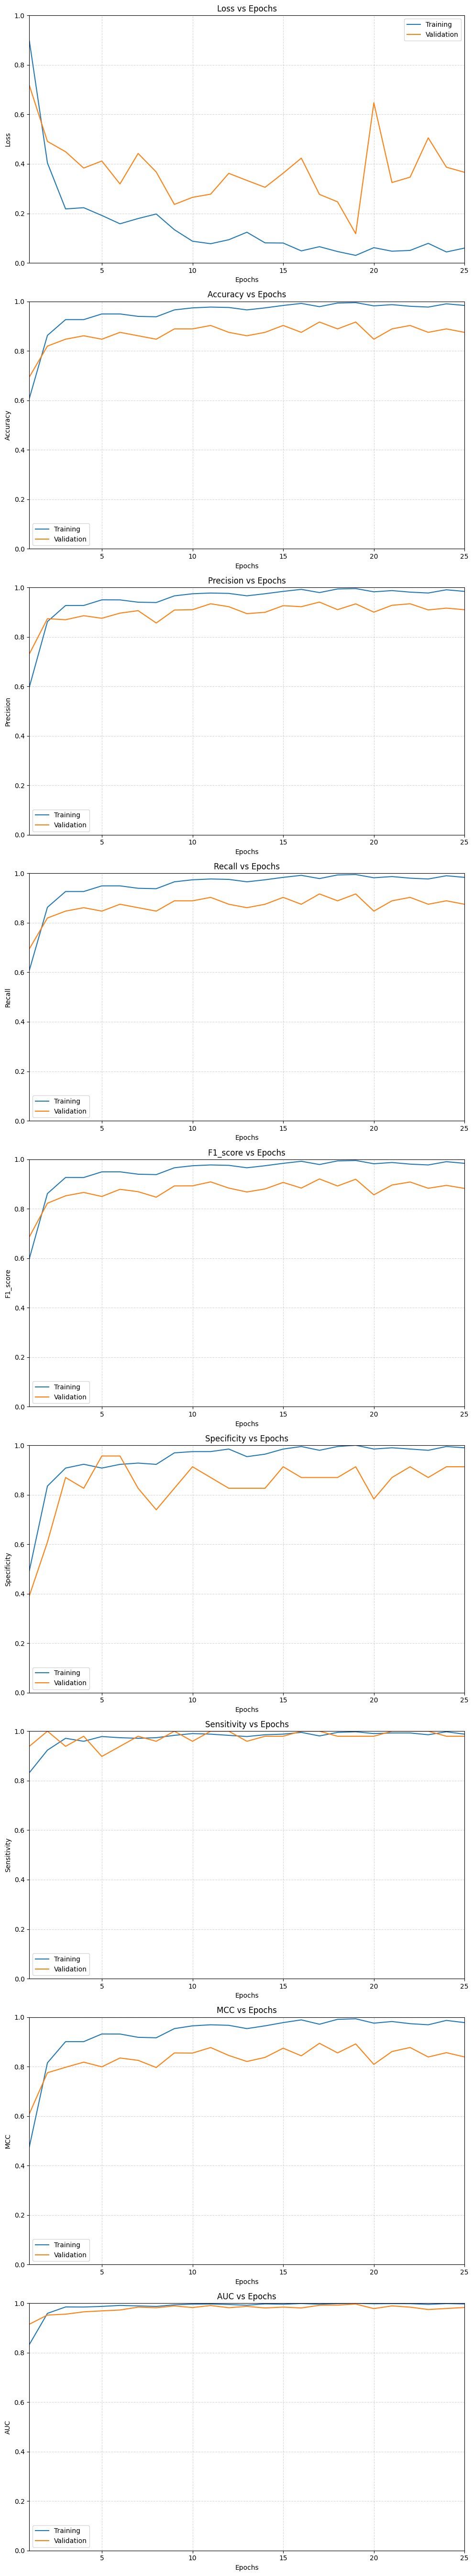

In [33]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(f"{metric_name.upper()} vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(f"{metric_name.capitalize()} vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        # Adjust xlim to avoid identical low and high limits.
        if num_epochs == 1:
            ax.set_xlim(0.5, 1.5)
        else:
            ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [34]:
# Testing loop
model.eval()
total_test_loss = 0.0
all_test_predictions = []
all_test_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_test_loss += loss.item()

        all_test_predictions.extend(outputs.detach().cpu().numpy())
        all_test_targets.extend(targets.detach().cpu().numpy())

all_test_predictions = np.array(all_test_predictions)
all_test_targets = np.array(all_test_targets)

average_test_loss = total_test_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_test_predictions), torch.tensor(all_test_targets), average_test_loss)
testing_metrics_line = "Test Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in test_metrics.items()])
print(testing_metrics_line)

Testing Model: 100%|██████████| 53/53 [00:03<00:00, 15.83it/s]

Test Metrics - loss: 0.2595, accuracy: 0.9302, precision: 0.9352, recall: 0.9302, f1_score: 0.9301, specificity: 0.8583, sensitivity: 0.9846, mcc: 0.9057, auc: 0.9837


In [35]:
# Convert true labels and predictions to numpy
true_labels = np.array(all_test_targets)
predicted_labels = np.argmax(np.array(all_test_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# Use dataset-derived class names (AUTO, SAFE)
classes = CLASS_NAMES

# Classification report
report = classification_report(
    true_labels,
    predicted_labels,
    target_names=classes,
    digits=4
)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(
    f"There were {num_errors} errors in {len(predicted_labels)} tests "
    f"for an accuracy of {accuracy*100:.2f}%"
)


                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib     0.9717    0.8583    0.9115       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa     0.8500    1.0000    0.9189        51
                                          normal     1.0000    0.9815    0.9907        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa     0.8958    0.9556    0.9247        90

                                        accuracy                         0.9302       315
                                       macro avg     0.9294    0.9488    0.9365       315
                                    weighted avg     0.9352    0.9302    0.9301       315

There were 22 errors in 315 tests for an accuracy of 93.02%
